In [1]:
!pip install -r requirements.txt

ERROR: Invalid requirement: 'timm=0.4.12': Expected end or semicolon (after name and no valid version specifier)
    timm=0.4.12
        ^ (from line 1 of requirements.txt)
Hint: = is not a valid operator. Did you mean == ?


In [2]:
# Consolidated imports
import os
import time
import json
import ast
import datetime
import argparse
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

import cv2
from sklearn.metrics import f1_score

import timm
from timm.models.layers import trunc_normal_
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.models.vision_transformer import VisionTransformer as TimmVisionTransformer, PatchEmbed

assert timm.__version__ >= "0.3.2"

print("Imports loaded.")

2025-09-06 13:30:12.268993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-06 13:30:12.881448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-06 13:30:15.002120: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Imports loaded.


# Utils

## lr_decay

In [3]:
# --------------------------------------------------------
# References:
# MAE: https://github.com/facebookresearch/mae
# ELECTRA https://github.com/google-research/electra
# BEiT: https://github.com/microsoft/unilm/tree/master/beit
# --------------------------------------------------------


def param_groups_lrd(model, weight_decay=0.05, no_weight_decay_list=[], layer_decay=.75):
    """
    Parameter groups for layer-wise lr decay
    Following BEiT: https://github.com/microsoft/unilm/blob/master/beit/optim_factory.py#L58
    """
    param_group_names = {}
    param_groups = {}

    num_layers = len(model.blocks) + 1

    layer_scales = list(layer_decay ** (num_layers - i) for i in range(num_layers + 1))

    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue

        # no decay: all 1D parameters and model specific ones
        if p.ndim == 1 or n in no_weight_decay_list:
            g_decay = "no_decay"
            this_decay = 0.
        else:
            g_decay = "decay"
            this_decay = weight_decay
            
        layer_id = get_layer_id_for_vit(n, num_layers)
        group_name = "layer_%d_%s" % (layer_id, g_decay)

        if group_name not in param_group_names:
            this_scale = layer_scales[layer_id]

            param_group_names[group_name] = {
                "lr_scale": this_scale,
                "weight_decay": this_decay,
                "params": [],
            }
            param_groups[group_name] = {
                "lr_scale": this_scale,
                "weight_decay": this_decay,
                "params": [],
            }

        param_group_names[group_name]["params"].append(n)
        param_groups[group_name]["params"].append(p)

    # print("parameter groups: \n%s" % json.dumps(param_group_names, indent=2))

    return list(param_groups.values())


def get_layer_id_for_vit(name, num_layers):
    """
    Assign a parameter with its layer id
    Following BEiT: https://github.com/microsoft/unilm/blob/master/beit/optim_factory.py#L33
    """
    if name in ['cls_token', 'pos_embed']:
        return 0
    elif name.startswith('patch_embed'):
        return 0
    elif name.startswith('blocks'):
        return int(name.split('.')[1]) + 1
    else:
        return num_layers

## pos_embed

In [4]:
# --------------------------------------------------------
# References:
# MAE: https://github.com/facebookresearch/mae
# --------------------------------------------------------

# --------------------------------------------------------
# 2D sine-cosine position embedding
# References:
# Transformer: https://github.com/tensorflow/models/blob/master/official/nlp/transformer/model_utils.py
# MoCo v3: https://github.com/facebookresearch/moco-v3
# --------------------------------------------------------
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_1d_sincos_pos_embed_from_grid_torch(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = torch.arange(embed_dim // 2, dtype=np.float32, device=pos.device)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = torch.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = torch.sin(out) # (M, D/2)
    emb_cos = torch.cos(out) # (M, D/2)

    emb = torch.cat([emb_sin, emb_cos], dim=1)  # (M, D)
    return emb.double()

# --------------------------------------------------------
# Interpolate position embeddings for high-resolution
# References:
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------
def interpolate_pos_embed(model, checkpoint_model):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        try:
            num_patches = model.patch_embed.num_patches
        except AttributeError as err:
            num_patches = model.patch_embed[0].num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed

# Models

## VIT

In [5]:
# --------------------------------------------------------
# References:
# MAE: https://github.com/facebookresearch/mae
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------

class VisionTransformer(TimmVisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches ** .5),
                                            cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome


def vit_base_patch16(**kwargs):
    model = VisionTransformer(embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16(**kwargs):
    model = VisionTransformer(embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
                              norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

## VIT Group Channels

In [6]:
# --------------------------------------------------------
# References:
# MAE: https://github.com/facebookresearch/mae
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# --------------------------------------------------------

class GroupChannelsVisionTransformer(TimmVisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, channel_embed=256,
                 channel_groups=((0, 1, 2, 6), (3, 4, 5, 7), (8, 9)), **kwargs):
        super().__init__(**kwargs)
        img_size = kwargs['img_size']
        patch_size = kwargs['patch_size']
        in_c = kwargs['in_chans']
        embed_dim = kwargs['embed_dim']

        self.channel_groups = channel_groups

        self.patch_embed = nn.ModuleList([PatchEmbed(img_size, patch_size, len(group), embed_dim)
                                          for group in channel_groups])
        num_patches = self.patch_embed[0].num_patches

        # Positional and channel embed
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim - channel_embed))
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(num_patches ** .5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        num_groups = len(channel_groups)
        self.channel_embed = nn.Parameter(torch.zeros(1, num_groups, channel_embed))
        chan_embed = get_1d_sincos_pos_embed_from_grid(self.channel_embed.shape[-1], torch.arange(num_groups).numpy())
        self.channel_embed.data.copy_(torch.from_numpy(chan_embed).float().unsqueeze(0))

        # Extra embedding for cls to fill embed_dim
        self.channel_cls_embed = nn.Parameter(torch.zeros(1, 1, channel_embed))
        channel_cls_embed = torch.zeros((1, channel_embed))
        self.channel_cls_embed.data.copy_(channel_cls_embed.float().unsqueeze(0))

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        b, c, h, w = x.shape

        x_c_embed = []
        for i, group in enumerate(self.channel_groups):
            x_c = x[:, group, :, :]
            x_c_embed.append(self.patch_embed[i](x_c))  # (N, L, D)

        x = torch.stack(x_c_embed, dim=1)  # (N, G, L, D)
        _, G, L, D = x.shape

        # add channel embed
        channel_embed = self.channel_embed.unsqueeze(2)  # (1, c, 1, cD)
        pos_embed = self.pos_embed[:, 1:, :].unsqueeze(1)  # (1, 1, L, pD)

        # Channel embed same across (x,y) position, and pos embed same across channel (c)
        channel_embed = channel_embed.expand(-1, -1, pos_embed.shape[2], -1)  # (1, c, L, cD)
        pos_embed = pos_embed.expand(-1, channel_embed.shape[1], -1, -1)  # (1, c, L, pD)
        pos_channel = torch.cat((pos_embed, channel_embed), dim=-1)  # (1, c, L, D)

        # add pos embed w/o cls token
        x = x + pos_channel  # (N, G, L, D)
        x = x.view(b, -1, D)  # (N, G*L, D)

        cls_pos_channel = torch.cat((self.pos_embed[:, :1, :], self.channel_cls_embed), dim=-1)  # (1, 1, D)
        cls_tokens = cls_pos_channel + self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (N, 1 + c*L, D)
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome


def vit_base_patch16(**kwargs):
    model = GroupChannelsVisionTransformer(channel_embed=256, embed_dim=768, depth=12,
                                           num_heads=12, mlp_ratio=4, qkv_bias=True,
                                           norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def vit_large_patch16(**kwargs):
    model = GroupChannelsVisionTransformer(channel_embed=256, embed_dim=1024, depth=24,
                                           num_heads=16, mlp_ratio=4, qkv_bias=True,
                                           norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

# Finetune

In [ ]:
# Configuration Class for Notebook
class Config:
    """Configuration class to replace argparse for notebook usage"""
    def __init__(self):
        # Training parameters
        self.batch_size = 16
        self.epochs = 30
        
        # Model parameters
        self.model_type = 'vanilla'  # or 'group_c'
        self.model = 'vit_large_patch16'
        self.input_size = 96
        self.patch_size = 8
        self.drop_path = 0.2
        
        # Optimizer parameters
        self.clip_grad = None
        self.weight_decay = 0.05
        self.lr = 1e-4
        self.layer_decay = 0.75
        self.warmup_epochs = 5
        
        # Augmentation parameters
        self.smoothing = 0
        self.mixup = 0.0
        self.cutmix = 0.0
        
        # Finetuning params
        self.finetune = None  # Path to pretrained checkpoint
        self.global_pool = True
        
        # Dataset parameters - Updated for current workspace
        self.data_path = '/home/ed/kickoff_pack'
        self.train_csv = 'data/train.csv'
        self.val_csv = 'data/val.csv'
        self.images_dir = 'images'
        self.kaggle_path = None
        
        # Model specific
        self.grouped_bands = []  # For GroupC vit
        self.nb_classes = 10
        
        # Output and logging
        self.output_dir = './finetune_logs_kaggle'
        self.log_dir = './finetune_logs_kaggle'
        self.device = 'cuda'
        self.seed = 0
        self.resume = None
        self.save_every = 5
        
        # Runtime parameters
        self.start_epoch = 0
        self.eval = False
        self.num_workers = 4
        self.pin_mem = True

# Create configuration instance
args = Config()

# Initialize metrics tracking lists
train_losses = []
val_losses = []
f1_hist_train = []
f1_hist_val = []

print("Configuration created successfully!")
print("Key settings:")
print(f"  Model type: {args.model_type}")
print(f"  Model: {args.model}")
print(f"  Batch size: {args.batch_size}")
print(f"  Epochs: {args.epochs}")
print(f"  Learning rate: {args.lr}")
print(f"  Data path: {args.data_path}")
print(f"  Output dir: {args.output_dir}")
print("Metrics tracking initialized!")

Configuration created successfully!
Key settings:
  Model type: vanilla
  Model: vit_large_patch16
  Batch size: 16
  Epochs: 2
  Learning rate: 0.0001
  Data path: /home/ed/kickoff_pack
  Output dir: ./finetune_logs_kaggle
Metrics tracking initialized!


In [8]:
# --------------------------------------------------------
# Simplified Single-GPU version of SatMAE++ fine-tuning for Kaggle Dataset
# Modified to work with NASA Geographical Objects dataset
# --------------------------------------------------------


class KaggleGeographicalDataset(Dataset):
    """Custom dataset for NASA Geographical Objects from Kaggle"""
    
    def __init__(self, csv_file, images_dir, transform=None, target_transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform
        self.target_transform = target_transform
        
        # Number of channels (RGB = 3)
        self.in_c = 3
        
        # Filter out missing images during initialization
        print(f"Checking for missing images in {images_dir}...")
        valid_indices = []
        missing_count = 0
        
        for idx, row in self.data.iterrows():
            img_name = row['FileName']
            img_path = os.path.join(images_dir, img_name)
            if os.path.exists(img_path):
                valid_indices.append(idx)
            else:
                missing_count += 1
                if missing_count <= 5:  # Only print first 5 missing files
                    print(f"Missing image: {img_path}")
                    
        if missing_count > 5:
            print(f"... and {missing_count - 5} more missing images")
            
        print(f"Found {len(valid_indices)} valid images out of {len(self.data)} total ({missing_count} missing)")
        
        # Keep only rows with existing images
        self.data = self.data.iloc[valid_indices].reset_index(drop=True)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get image path and load image
        img_name = self.data.iloc[idx]['FileName']
        img_path = os.path.join(self.images_dir, img_name)
        
        # Load image using cv2 (BGR format)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Get label vector and convert to tensor
        label_str = self.data.iloc[idx]['Label Vector']
        label_vector = ast.literal_eval(label_str)  # Convert string to list
        label = torch.tensor(label_vector, dtype=torch.float32)
        
        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)
        else:
            # Default preprocessing: resize, normalize, and convert to tensor
            image = cv2.resize(image, (96, 96))  # Resize to 96x96 (SatMAE default)
            image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
            image = torch.from_numpy(image).permute(2, 0, 1)  # HWC to CHW
        
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label


def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0):
    """Cosine learning rate scheduler with warmup"""
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters))) / 2

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule


def train_one_epoch_simple(model, criterion, data_loader, optimizer, device, epoch, 
                          clip_grad=None, mixup_fn=None, lr_schedule=None):
    """Simplified training loop for one epoch"""
    model.train()
    
    total_loss = 0.0
    total_samples = 0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (samples, targets) in enumerate(data_loader):
        # Update learning rate
        if lr_schedule is not None:
            it = epoch * len(data_loader) + batch_idx
            if it < len(lr_schedule):
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_schedule[it]
        
        samples = samples.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            samples, targets = mixup_fn(samples, targets)

        optimizer.zero_grad()
        
        outputs = model(samples)
        loss = criterion(outputs, targets)
        
        loss.backward()
        
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        
        optimizer.step()
        
        total_loss += loss.item()
        total_samples += samples.size(0)
        
        # Store predictions and targets for F1 calculation (only if not using mixup)
        if mixup_fn is None:
            with torch.no_grad():
                preds = torch.sigmoid(outputs) > 0.5
                all_predictions.append(preds.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
        
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}/{len(data_loader)}, '
                  f'Loss: {loss.item():.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    avg_loss = total_loss / len(data_loader)
    
    # Calculate F1 score if we have predictions
    if all_predictions and mixup_fn is None:
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)
        f1_micro = f1_score(all_targets, all_predictions, average='micro')
        f1_macro = f1_score(all_targets, all_predictions, average='macro')
    else:
        f1_micro = f1_macro = 0.0
    
    return {'loss': avg_loss, 'f1_micro': f1_micro, 'f1_macro': f1_macro}


def evaluate_simple(model, data_loader, device):
    """Simplified evaluation"""
    model.eval()
    
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    criterion = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        for samples, targets in data_loader:
            samples = samples.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            outputs = model(samples)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            
            # Store predictions
            preds = torch.sigmoid(outputs) > 0.5
            all_predictions.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Calculate metrics
    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    
    f1_micro = f1_score(all_targets, all_predictions, average='micro')
    f1_macro = f1_score(all_targets, all_predictions, average='macro')
    avg_loss = total_loss / len(data_loader)
    
    return {'loss': avg_loss, 'f1_micro': f1_micro, 'f1_macro': f1_macro}


def save_checkpoint(model, optimizer, epoch, args, filename=None):
    """Save model checkpoint"""
    if filename is None:
        filename = f'checkpoint_epoch_{epoch}.pth'
    
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'args': args,
    }
    
    filepath = os.path.join(args.output_dir, filename)
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")


def find_images_path(args):
    """Find the correct path for images"""
    possible_paths = [
        os.path.join(args.data_path, args.images_dir),
    ]
    
    # If kaggle_path is provided, try that too
    if args.kaggle_path:
        possible_paths.insert(0, os.path.join(args.kaggle_path, 'images'))
    
    # Also try common kaggle download locations
    home_dir = os.path.expanduser("~")
    kaggle_cache = os.path.join(home_dir, '.cache', 'kagglehub')
    if os.path.exists(kaggle_cache):
        # Look for any directory containing images
        for root, dirs, files in os.walk(kaggle_cache):
            if 'images' in dirs:
                possible_paths.append(os.path.join(root, 'images'))
    
    for path in possible_paths:
        if os.path.exists(path):
            # Check if it actually contains image files
            image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            if len(image_files) > 0:
                print(f"Found {len(image_files)} images in: {path}")
                return path
    
    print(f"Warning: No images found in any of these paths: {possible_paths}")
    return os.path.join(args.data_path, args.images_dir)  # fallback


def main(args):
    # Access global variables for metrics tracking
    global train_losses, val_losses, f1_hist_train, f1_hist_val
    
    # Reset metrics at start of training
    train_losses = []
    val_losses = []
    f1_hist_train = []
    f1_hist_val = []
    
    print('Single GPU Training - Kaggle Geographical Dataset')
    print('Working directory: {}'.format(os.getcwd()))  # Fixed: Use os.getcwd() instead of __file__
    print("Configuration:")
    
    # Print config in a readable format
    config_dict = {k: v for k, v in vars(args).items()}
    for key, value in config_dict.items():
        print(f"  {key}: {value}")

    device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # fix the seed for reproducibility
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    cudnn.benchmark = True

    # Build datasets
    train_csv_path = os.path.join(args.data_path, args.train_csv)
    val_csv_path = os.path.join(args.data_path, args.val_csv)
    images_path = os.path.join(args.data_path, args.images_dir)
    
    # Check if images directory exists, if not try alternative locations
    if not os.path.exists(images_path):
        print(f"Images directory not found at: {images_path}")
        
        # Try some alternative locations
        alternative_paths = [
            os.path.join(args.data_path, '..', '__MACOSX', 'kickoff_pack', 'images'),
            os.path.join(args.data_path, '..', 'images'),
            '/tmp/nasa-geographical-objects-multilabel-dataset/images',
            # Add kagglehub cache locations
            os.path.expanduser('~/.cache/kagglehub/datasets/olebro/nasa-geographical-objects-multilabel-dataset/versions/1/images'),
            os.path.expanduser('~/.cache/kagglehub/datasets/olebro/nasa-geographical-objects-multilabel-dataset/versions/2/images'),
        ]
        
        for alt_path in alternative_paths:
            if os.path.exists(alt_path):
                print(f"Found images at alternative location: {alt_path}")
                images_path = alt_path
                break
        else:
            print("Warning: No images directory found. Please check the data setup.")
            print("Available directories:")
            for item in os.listdir(args.data_path):
                item_path = os.path.join(args.data_path, item)
                if os.path.isdir(item_path):
                    print(f"  - {item}/")
    
    print("Loading datasets...")
    print(f"Train CSV: {train_csv_path}")
    print(f"Val CSV: {val_csv_path}")
    print(f"Images path: {images_path}")
    
    dataset_train = KaggleGeographicalDataset(train_csv_path, images_path)
    dataset_val = KaggleGeographicalDataset(val_csv_path, images_path)

    print(f"Train dataset size: {len(dataset_train)}")
    print(f"Val dataset size: {len(dataset_val)}")

    # Setup logging
    if args.log_dir is not None and not args.eval:
        os.makedirs(args.log_dir, exist_ok=True)
        log_writer = SummaryWriter(log_dir=args.log_dir)
    else:
        log_writer = None

    # Data loaders
    data_loader_train = DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
    )

    data_loader_val = DataLoader(
        dataset_val,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=False
    )

    # Setup mixup (disabled by default for this dataset)
    mixup_fn = None
    mixup_active = args.mixup > 0 or args.cutmix > 0.
    if mixup_active:
        print("Mixup is activated!")
        mixup_fn = Mixup(
            mixup_alpha=args.mixup, cutmix_alpha=args.cutmix,
            prob=1.0, switch_prob=0.5, mode='batch',
            label_smoothing=args.smoothing, num_classes=args.nb_classes)

    # Import the appropriate model module based on model_type
    if args.model_type == 'group_c':
        print("Using SatMAE Group Channel model")
        if len(args.grouped_bands) == 0:
            args.grouped_bands = [[0, 1, 2]]  # RGB channels
        
        print(f"Grouping bands {args.grouped_bands}")
        # Use the GroupChannelsVisionTransformer we defined earlier
        if args.model == 'vit_base_patch16':
            model = GroupChannelsVisionTransformer(
                patch_size=args.patch_size, img_size=args.input_size, in_chans=dataset_train.in_c,
                channel_groups=args.grouped_bands, num_classes=args.nb_classes,
                drop_path_rate=args.drop_path, global_pool=args.global_pool,
                channel_embed=256, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
                norm_layer=partial(nn.LayerNorm, eps=1e-6)
            )
        elif args.model == 'vit_large_patch16':
            model = GroupChannelsVisionTransformer(
                patch_size=args.patch_size, img_size=args.input_size, in_chans=dataset_train.in_c,
                channel_groups=args.grouped_bands, num_classes=args.nb_classes,
                drop_path_rate=args.drop_path, global_pool=args.global_pool,
                channel_embed=256, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
                norm_layer=partial(nn.LayerNorm, eps=1e-6)
            )
    
    elif args.model_type == 'vanilla':
        print("Using SatMAE Vanilla model")
        # Use the VisionTransformer we defined earlier
        if args.model == 'vit_base_patch16':
            model = VisionTransformer(
                patch_size=args.patch_size, img_size=args.input_size, in_chans=dataset_train.in_c,
                num_classes=args.nb_classes, drop_path_rate=args.drop_path, global_pool=args.global_pool,
                embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
                norm_layer=partial(nn.LayerNorm, eps=1e-6)
            )
        elif args.model == 'vit_large_patch16':
            model = VisionTransformer(
                patch_size=args.patch_size, img_size=args.input_size, in_chans=dataset_train.in_c,
                num_classes=args.nb_classes, drop_path_rate=args.drop_path, global_pool=args.global_pool,
                embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
                norm_layer=partial(nn.LayerNorm, eps=1e-6)
            )
    
    else:
        raise ValueError(f"Unknown model type: {args.model_type}")

    # Load pre-trained weights if available
    if args.finetune and not args.eval:
        if os.path.exists(args.finetune):
            checkpoint = torch.load(args.finetune, map_location='cpu', weights_only=False)
            print("Load pre-trained checkpoint from: %s" % args.finetune)
            
            if 'model' in checkpoint:
                checkpoint_model = checkpoint['model']
            else:
                checkpoint_model = checkpoint
                
            state_dict = model.state_dict()

            # Remove incompatible keys for SatMAE models
            for k in ['pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'head.weight', 'head.bias']:
                if k in checkpoint_model and k in state_dict and checkpoint_model[k].shape != state_dict[k].shape:
                    print(f"Removing key {k} from pretrained checkpoint")
                    del checkpoint_model[k]
            
            # interpolate position embedding
            interpolate_pos_embed(model, checkpoint_model)

            # Load pre-trained model
            msg = model.load_state_dict(checkpoint_model, strict=False)
            print(f"Loading checkpoint: {msg}")

            # manually initialize fc layer for SatMAE models
            trunc_normal_(model.head.weight, std=2e-5)
        else:
            print(f"Checkpoint file {args.finetune} not found. Training from scratch.")

    model.to(device)
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Model = %s" % str(model))
    print('number of params (M): %.2f' % (n_parameters / 1.e6))

    # Build optimizer - Use layer-wise learning rate decay for SatMAE models
    param_groups = param_groups_lrd(model, args.weight_decay,
                                    no_weight_decay_list=model.no_weight_decay(),
                                    layer_decay=args.layer_decay)
    optimizer = torch.optim.AdamW(param_groups, lr=args.lr)

    # Setup criterion
    if mixup_fn is not None:
        criterion = SoftTargetCrossEntropy()
    elif args.smoothing > 0.:
        criterion = LabelSmoothingCrossEntropy(smoothing=args.smoothing)
    else:
        criterion = nn.BCEWithLogitsLoss()  # For multi-label classification

    print("criterion = %s" % str(criterion))

    # Setup learning rate schedule
    lr_schedule = cosine_scheduler(
        args.lr, 1e-6, args.epochs, len(data_loader_train),
        warmup_epochs=args.warmup_epochs, start_warmup_value=1e-6
    )

    # Resume from checkpoint if specified
    start_epoch = args.start_epoch
    if args.resume:
        if os.path.exists(args.resume):
            checkpoint = torch.load(args.resume, map_location='cpu', weights_only=False)
            model.load_state_dict(checkpoint['model'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            start_epoch = checkpoint['epoch'] + 1
            print(f"Resumed from checkpoint: {args.resume}, epoch {start_epoch}")

    # Evaluation only
    if args.eval:
        test_stats = evaluate_simple(model, data_loader_val, device)
        print(f"Evaluation on {len(dataset_val)} test images:")
        print(f"Loss: {test_stats['loss']:.4f}")
        print(f"F1 Micro: {test_stats['f1_micro']:.4f}")
        print(f"F1 Macro: {test_stats['f1_macro']:.4f}")
        return

    # Training loop
    print(f"Start training for {args.epochs} epochs")
    start_time = time.time()
    best_f1 = 0.0
    
    for epoch in range(start_epoch, args.epochs):
        print(f"\nEpoch {epoch}/{args.epochs}")
        
        # Training
        train_stats = train_one_epoch_simple(
            model, criterion, data_loader_train, optimizer, device, epoch,
            clip_grad=args.clip_grad, mixup_fn=mixup_fn, lr_schedule=lr_schedule
        )

        # Validation
        test_stats = evaluate_simple(model, data_loader_val, device)

        # Store metrics for visualization
        train_losses.append(train_stats['loss'])
        val_losses.append(test_stats['loss'])
        f1_hist_train.append(train_stats['f1_micro'])
        f1_hist_val.append(test_stats['f1_micro'])

        print(f"Training - Loss: {train_stats['loss']:.4f}, F1 Micro: {train_stats['f1_micro']:.4f}, F1 Macro: {train_stats['f1_macro']:.4f}")
        print(f"Validation - Loss: {test_stats['loss']:.4f}, F1 Micro: {test_stats['f1_micro']:.4f}, F1 Macro: {test_stats['f1_macro']:.4f}")
        
        best_f1 = max(best_f1, test_stats["f1_micro"])
        print(f'Best F1 Micro so far: {best_f1:.4f}')

        # Logging
        if log_writer is not None:
            log_writer.add_scalar('train/loss', train_stats['loss'], epoch)
            log_writer.add_scalar('train/f1_micro', train_stats['f1_micro'], epoch)
            log_writer.add_scalar('train/f1_macro', train_stats['f1_macro'], epoch)
            log_writer.add_scalar('val/loss', test_stats['loss'], epoch)
            log_writer.add_scalar('val/f1_micro', test_stats['f1_micro'], epoch)
            log_writer.add_scalar('val/f1_macro', test_stats['f1_macro'], epoch)
            log_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], epoch)

        # Save checkpoint
        if args.output_dir and (epoch % args.save_every == 0 or epoch + 1 == args.epochs):
            save_checkpoint(model, optimizer, epoch, args)

        # Save logs
        log_stats = {
            **{f'train_{k}': v for k, v in train_stats.items()},
            **{f'test_{k}': v for k, v in test_stats.items()},
            'epoch': epoch,
            'n_parameters': n_parameters,
            'best_f1_micro': best_f1
        }

        if args.output_dir:
            with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
                f.write(json.dumps(log_stats) + "\n")

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f'\nTraining completed in {total_time_str}')
    print(f'Final best F1 Micro: {best_f1:.4f}')

    if log_writer is not None:
        log_writer.close()

    # Print metrics summary
    print(f"\nMetrics collected for {len(train_losses)} epochs:")
    print(f"Train losses: {len(train_losses)} values")
    print(f"Val losses: {len(val_losses)} values")
    print(f"F1 train: {len(f1_hist_train)} values")
    print(f"F1 val: {len(f1_hist_val)} values")


# Create output directory if it doesn't exist
if args.output_dir:
    Path(args.output_dir).mkdir(parents=True, exist_ok=True)

print("Ready to run training!")
print("You can now call: main(args)")

Ready to run training!
You can now call: main(args)


In [9]:
# Run the training
# Uncomment the line below to start training
main(args)

Single GPU Training - Kaggle Geographical Dataset
Working directory: /home/ed/satmae_pp
Configuration:
  batch_size: 16
  epochs: 2
  model_type: vanilla
  model: vit_large_patch16
  input_size: 96
  patch_size: 8
  drop_path: 0.2
  clip_grad: None
  weight_decay: 0.05
  lr: 0.0001
  layer_decay: 0.75
  warmup_epochs: 2
  smoothing: 0
  mixup: 0.0
  cutmix: 0.0
  finetune: None
  global_pool: True
  data_path: /home/ed/kickoff_pack
  train_csv: data/train.csv
  val_csv: data/val.csv
  images_dir: images
  kaggle_path: None
  grouped_bands: []
  nb_classes: 10
  output_dir: ./finetune_logs_kaggle
  log_dir: ./finetune_logs_kaggle
  device: cuda
  seed: 0
  resume: None
  save_every: 5
  start_epoch: 0
  eval: False
  num_workers: 4
  pin_mem: True
Using device: cuda
Images directory not found at: /home/ed/kickoff_pack/images
Found images at alternative location: /home/ed/.cache/kagglehub/datasets/olebro/nasa-geographical-objects-multilabel-dataset/versions/1/images
Loading datasets...
T

# Training Metrics Visualization

This section provides visualization of the training metrics collected during the SatMAE fine-tuning process.

The plots show:
- **Left plot**: Training and validation loss over epochs
- **Right plot**: Training and validation F1 scores over epochs

Note: The visualization will only show data after training has been completed or partially run.

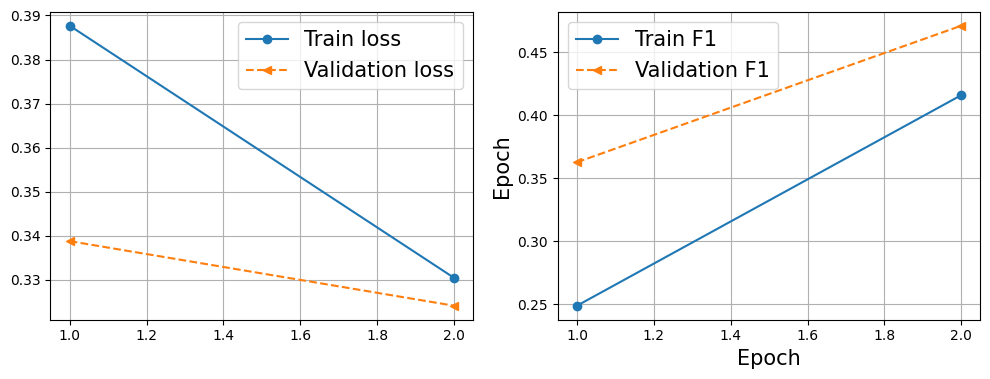

In [ ]:
x_axis = np.arange(args.epochs) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, train_losses, '-o', label = 'Train loss')
ax.plot(x_axis, val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax.grid(True)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, f1_hist_train, '-o', label='Train F1')
ax.plot(x_axis, f1_hist_val, '--<', label='Validation F1')
ax.legend(fontsize=15)
ax.grid(True)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
plt.show()